In [160]:
# imports
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from tqdm import tqdm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [142]:
def kernel_linear(a, b):
    return np.dot(a, b)

def kernel_gauss(a, b, beta):
    return np.exp(-beta * np.power(np.linalg.norm(a - b), 2))

def kernel_polynom(a, b, degree):
    return np.power(np.dot(a, b) + 1, degree)

def get_kernel_func(name, beta, degree):
    if name == "linear":
        return lambda a, b: kernel_linear(a, b)
    elif name == "gauss":
        return lambda a, b: kernel_gauss(a, b, beta)
    elif name == "polynom":
        return lambda a, b: kernel_polynom(a, b, degree)
    else:
        return lambda a, b: kernel_linear(a, b)

In [143]:
def calc_kernel_matrix(kernel_f, A, B):
    n, *_ = A.shape
    m, *_ = B.shape
    f = lambda i, j: kernel_f(A[i], B[j])
    return np.fromfunction(np.vectorize(f), (n, m), dtype=int)

In [144]:
class SVM:
    def __init__(self, kernel_f, kernel_values, value, C=1.0):
        n, *_ = value.shape
        self.N = n
        self.kernel_f = kernel_f
        self.value = value
        self.kernel = calc_kernel_matrix(kernel_f, kernel_values, kernel_values)
        self.kernel_values = kernel_values
        self.C = C
        
        self.alpha = np.zeros(n)
        self.b = 0
        
        self.EPS = 1e-8
        self.MAX_ITERATIONS = 3000
        
    def predict(self,kernel_values):
        kernel = calc_kernel_matrix(self.kernel_f, np.array([kernel_values]), self.kernel_values)
        res = int(np.sign(np.sum(self.alpha * self.value * kernel[0]) + self.b))
        return res if res != 0 else 1
    
    def get_random_j(self, i):
        res = np.random.randint(0, self.N - 1);
        return res if res < i else res + 1
    
    def calc_L_H(self, i, j):
        a_i, a_j = self.alpha[i], self.alpha[j]
        if self.value[i] == self.value[j]:
            L = max(0, a_i + a_j - self.C)
            H = min(self.C, a_i + a_j)
        else:
            L = max(0, a_j - a_i)
            H = min(self.C, self.C + a_j - a_i)
        return L, H
    
    def calc_E(self, i):
        return np.dot(self.alpha * self.value, self.kernel[i]) - self.value[i]
    
    def get_b(self, i):
        return 1 / self.value[i] - np.dot(self.alpha * self.value, self.kernel[i])
    
    def calc_b(self):
        self.b = 0
        idx = None
        for i in range(self.N):
            if  self.alpha[i] > self.EPS and self.alpha[i] + self.EPS < self.C:
                idx = i
                break
        if idx is None:
            cnt = 0
            for i in range(self.N):
                if self.alpha[i] > self.EPS:
                    self.b += self.get_b(i)
                    cnt += 1
            if cnt != 0:
                self.b /= cnt
        else:
            self.b = self.get_b(idx)
            
    def fit(self):
        indices = np.arange(self.N)
        for _ in range(self.MAX_ITERATIONS):
            np.random.shuffle(indices)
            for index_index in range(self.N):
                i = indices[index_index]
                j = indices[self.get_random_j(index_index)]
                
                L, H = self.calc_L_H(i, j)
                if H - L < self.EPS:
                    continue
                eta = 2 * self.kernel[i][j] - (self.kernel[i][i] + self.kernel[j][j])
                if eta > -self.EPS:
                    continue
                    
                E_i = self.calc_E(i)
                E_j = self.calc_E(j)
                alpha2 = self.alpha[j]
                
                a2 = alpha2 + self.value[j] * (E_j - E_i) / eta
                a2 = min(max(L, a2), H)
                if abs(a2 - alpha2) < self.EPS:
                    continue
                
                self.alpha[j] = a2
                self.alpha[i] += self.value[i] * self.value[j] * (alpha2 - a2)
        self.calc_b()
            
    def get_support_indices(self):
        return np.where(np.logical_and(self.alpha > self.EPS,
                                       self.alpha + self.EPS < self.C))

In [145]:
Cs = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
linear_params = [{"name": "linear", "C": C} for C in Cs]
gauss_params = [{"name": "gauss", "beta": beta, "C": C} 
             for beta in [1, 2, 3, 4, 5]
             for C in Cs]
polynom_params = [{"name": "polynom", "C": C, "degree": degree}
               for degree in [2, 3, 4, 5]
               for C in Cs]
all_params = np.array(linear_params + gauss_params + polynom_params)
print(all_params)

[{'name': 'linear', 'C': 0.05} {'name': 'linear', 'C': 0.1}
 {'name': 'linear', 'C': 0.5} {'name': 'linear', 'C': 1.0}
 {'name': 'linear', 'C': 5.0} {'name': 'linear', 'C': 10.0}
 {'name': 'linear', 'C': 50.0} {'name': 'linear', 'C': 100.0}
 {'name': 'gauss', 'beta': 1, 'C': 0.05}
 {'name': 'gauss', 'beta': 1, 'C': 0.1}
 {'name': 'gauss', 'beta': 1, 'C': 0.5}
 {'name': 'gauss', 'beta': 1, 'C': 1.0}
 {'name': 'gauss', 'beta': 1, 'C': 5.0}
 {'name': 'gauss', 'beta': 1, 'C': 10.0}
 {'name': 'gauss', 'beta': 1, 'C': 50.0}
 {'name': 'gauss', 'beta': 1, 'C': 100.0}
 {'name': 'gauss', 'beta': 2, 'C': 0.05}
 {'name': 'gauss', 'beta': 2, 'C': 0.1}
 {'name': 'gauss', 'beta': 2, 'C': 0.5}
 {'name': 'gauss', 'beta': 2, 'C': 1.0}
 {'name': 'gauss', 'beta': 2, 'C': 5.0}
 {'name': 'gauss', 'beta': 2, 'C': 10.0}
 {'name': 'gauss', 'beta': 2, 'C': 50.0}
 {'name': 'gauss', 'beta': 2, 'C': 100.0}
 {'name': 'gauss', 'beta': 3, 'C': 0.05}
 {'name': 'gauss', 'beta': 3, 'C': 0.1}
 {'name': 'gauss', 'beta': 3

In [146]:
def get_classificator(params, kernel_values, values):
    name = params["name"]
    C = params["C"]
    beta = params.get("beta", None)
    degree = params.get("degree", None)
    kernel = get_kernel_func(name, beta, degree)
    classificator = SVM(kernel, kernel_values, values, C)
    classificator.fit()
    return classificator

def get_score(params, kernel_values, values):
    kf = KFold(4)
    f_scores = []
    for train_index, test_index in kf.split(kernel_values):
        X_train, y_train = kernel_values[train_index], values[train_index]
        X_test, y_test = kernel_values[test_index], values[test_index]
        classificator = get_classificator(params, X_train, y_train)
        y_pred = np.apply_along_axis(lambda x: classificator.predict(x), 1, X_test)
        f_scores.append(f1_score(y_test, y_pred))
    return np.average(np.array(f_scores))    

def get_best_params(kernel_values, values):
    best_score = -1
    best_params = {}
    total_params, *_ = all_params.shape
    for params in tqdm(all_params):
        name = params["name"]
        score = get_score(params, kernel_values, values)
        if name not in best_params:
            best_params[name] = (score, params)
        else:
            if score > best_params[name][0]:
                best_params[name] = (score, params)
    return best_params

In [156]:
def draw(params, kernel_values, values, step):
    classificator = get_classificator(params, kernel_values, values)
    stepx = step
    stepy = 0.01
    x_min, y_min = np.amin(kernel_values, 0)
    x_max, y_max = np.amax(kernel_values, 0)
    x_min -= stepx
    x_max += stepx
    y_min -= stepy
    y_max += stepy
    xx, yy = np.meshgrid(np.arange(x_min, x_max, stepx),
                         np.arange(y_min, y_max, stepy))
    
    mesh_dots = np.c_[xx.ravel(), yy.ravel()]
    zz = np.apply_along_axis(lambda t: classificator.predict(t), 1, mesh_dots)
    zz = np.array(zz).reshape(xx.shape)
    
    plt.figure(figsize=(10, 10))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    x0, y0 = kernel_values[values == -1].T
    x1, y1 = kernel_values[values == 1].T
    
    plt.pcolormesh(xx, yy, zz, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    plt.scatter(x0, y0, color='red', s=100)
    plt.scatter(x1, y1, color='blue', s=100)
    
    sup_ind = classificator.get_support_indices()
    X_sup = kernel_values[sup_ind]
    x_sup, y_sup = X_sup.T
    
    plt.scatter(x_sup, y_sup, color='white', marker='x', s=60)
    plt.show()

In [148]:
def read_dataset(filename):
    data = pd.read_csv(filename)
    kernel_values = data.values[:, :-1]
    tmp_values = data.values[:, -1]
    values = np.vectorize(lambda t: 1 if t == 'P' else -1)(tmp_values)
    indices = np.arange(values.shape[0])
    np.random.shuffle(indices)
    return kernel_values[indices], values[indices]

In [149]:
def get_best_params_from_dataset(filename):
    kernel_values, values = read_dataset(filename)
    return get_best_params(kernel_values, values), kernel_values, values

In [150]:
chips_best_params, chips_kernel_values, chips_values = get_best_params_from_dataset('chips.csv')
geyser_best_params, geyser_kernel_values, geyser_values = get_best_params_from_dataset('geyser.csv')

100%|██████████| 80/80 [51:36<00:00, 38.70s/it]


In [151]:
print(chips_best_params)
print(geyser_best_params)

{'linear': (0.5360554334238544, {'name': 'linear', 'C': 5.0}), 'gauss': (0.8150793650793652, {'name': 'gauss', 'beta': 1, 'C': 5.0}), 'polynom': (0.8163194444444445, {'name': 'polynom', 'C': 100.0, 'degree': 3})}
{'linear': (0.8545548697533342, {'name': 'linear', 'C': 0.5}), 'gauss': (0.8586716773953801, {'name': 'gauss', 'beta': 1, 'C': 0.5}), 'polynom': (0.859621256895193, {'name': 'polynom', 'C': 0.05, 'degree': 2})}


In [164]:
def draw_dataset(params, kernel_values, values, step):
    for kernel in params:
        draw(params[kernel][1], kernel_values, values, step)

<ipython-input-156-32fca97a8c74>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))


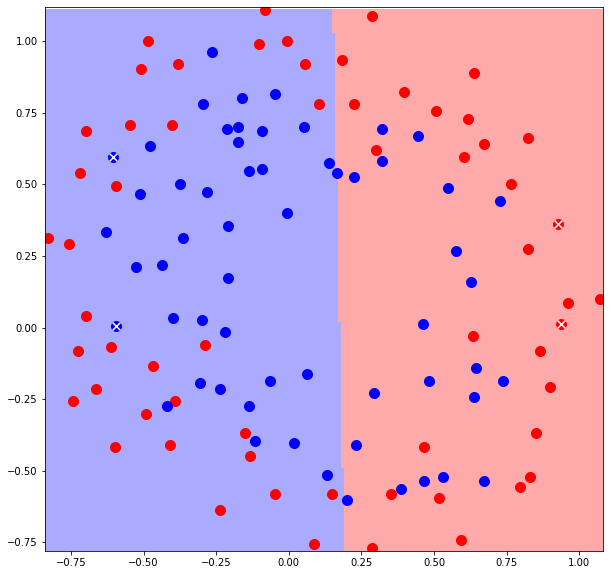

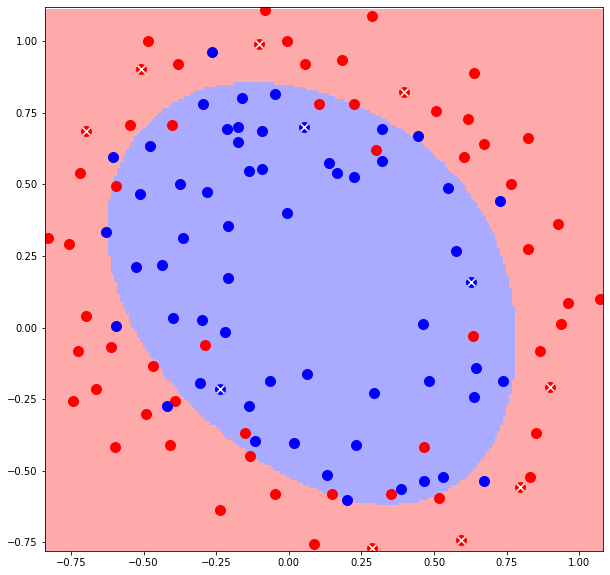

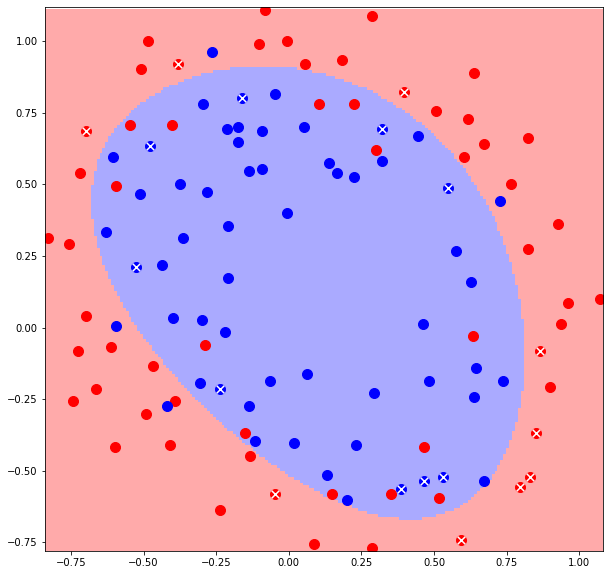

In [161]:
draw_dataset(chips_best_params, chips_kernel_values, chips_values, 0.01)

<ipython-input-156-32fca97a8c74>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))


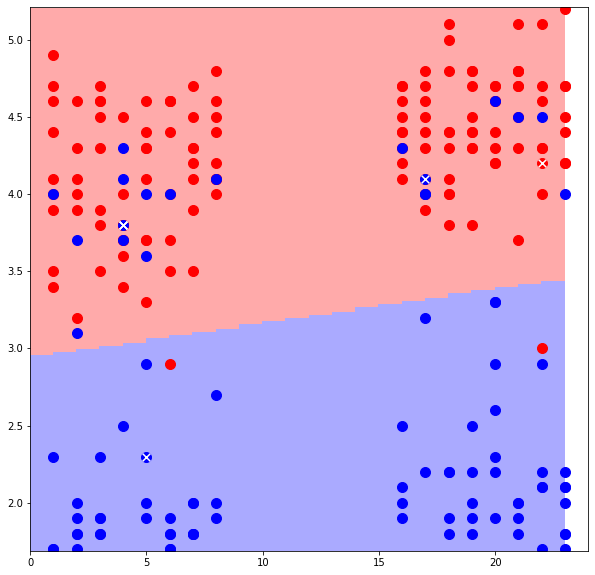

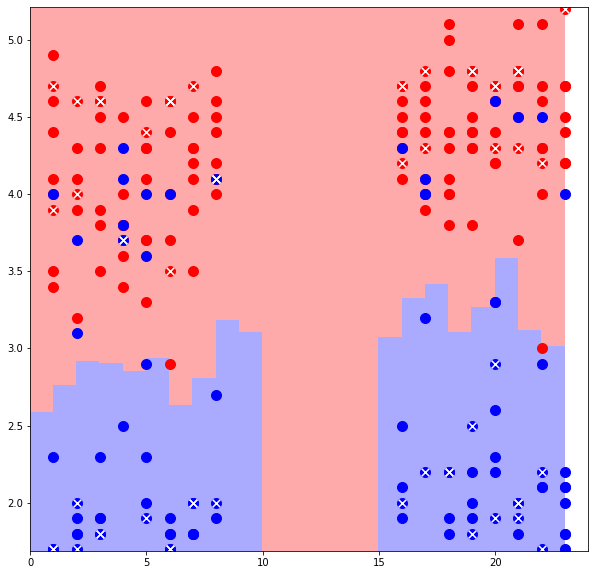

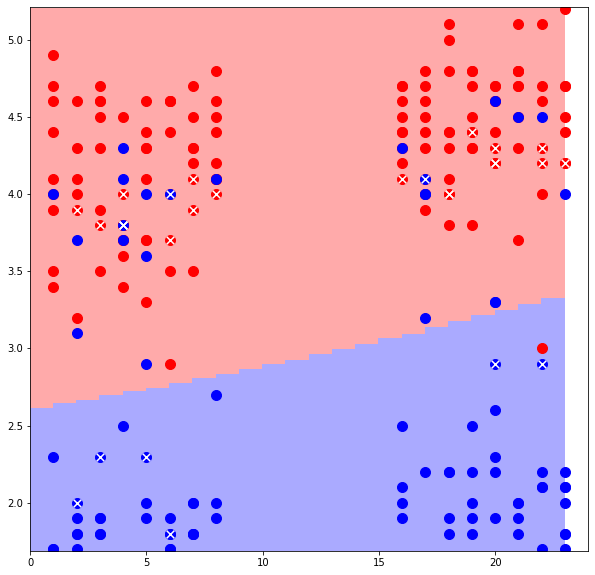

In [165]:
draw_dataset(geyser_best_params, geyser_kernel_values, geyser_values, 1)